<a href="https://colab.research.google.com/github/2eight9/Titanic-Survival-Classification/blob/main/Titanic_Survival_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h2>Final Project : Big Data & Predictive Analytics Lanjut  - TITANIC   <br>

**Anggota Kelompok :**

*   Apriliano Ernando Benyamin Boimau 22.11.4609 (IF05)
*   Muhammad Rifki                    22.11.4636 (IF05)
*   Syifaur Rahman Tharif             22.11.4636 (IF05)






Link Dataset : https://www.kaggle.com/datasets/sakshisatre/titanic-dataset


#Install PySpark dan Load Dataset

In [ ]:
#Instal dan Impor Pyspark
!pip install pyspark

In [ ]:
#Import library yang diperlukan
from pyspark.sql import SparkSession

#Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Inisialisasi Spark Session
spark = SparkSession.builder \
    .appName("Titanic Dataset Analysis") \
    .getOrCreate()

file_path = '/content/drive/MyDrive/BIG DATA LANJUT/Titanic Dataset/Titanic Dataset.csv'
df = spark.read.csv(file_path, header=True, inferSchema=True)

# Menampilkan beberapa baris pertama dari dataset
df.show(10)

+------+--------+--------------------+------+----+-----+-----+--------+--------+-------+--------+----+----+--------------------+
|pclass|survived|                name|   sex| age|sibsp|parch|  ticket|    fare|  cabin|embarked|boat|body|           home.dest|
+------+--------+--------------------+------+----+-----+-----+--------+--------+-------+--------+----+----+--------------------+
|     1|       1|Allen, Miss. Elis...|female|29.0|    0|    0|   24160|211.3375|     B5|       S|   2|NULL|        St Louis, MO|
|     1|       1|Allison, Master. ...|  male|0.92|    1|    2|  113781|  151.55|C22 C26|       S|  11|NULL|Montreal, PQ / Ch...|
|     1|       0|Allison, Miss. He...|female| 2.0|    1|    2|  113781|  151.55|C22 C26|       S|NULL|NULL|Montreal, PQ / Ch...|
|     1|       0|Allison, Mr. Huds...|  male|30.0|    1|    2|  113781|  151.55|C22 C26|       S|NULL| 135|Montreal, PQ / Ch...|
|     1|       0|Allison, Mrs. Hud...|female|25.0|    1|    2|  113781|  151.55|C22 C26|       S|

#Pre-Processing

In [ ]:
#Import Library yang dibutuhkan lagi
from pyspark.sql import functions as F
from pyspark.sql.types import IntegerType, DoubleType
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler


In [ ]:
#Memeriksa Tipe Data
print("Tipe Data:")
df.printSchema()

Tipe Data:
root
 |-- pclass: integer (nullable = true)
 |-- survived: integer (nullable = true)
 |-- name: string (nullable = true)
 |-- sex: string (nullable = true)
 |-- age: double (nullable = true)
 |-- sibsp: integer (nullable = true)
 |-- parch: integer (nullable = true)
 |-- ticket: string (nullable = true)
 |-- fare: double (nullable = true)
 |-- cabin: string (nullable = true)
 |-- embarked: string (nullable = true)
 |-- boat: string (nullable = true)
 |-- body: integer (nullable = true)
 |-- home.dest: string (nullable = true)



In [ ]:
# Mengganti nama kolom (misalnya, mengganti 'pclass' menjadi 'passenger_class')
df = df.withColumnRenamed("pclass", "passenger_class")

# Menampilkan skema setelah mengganti nama kolom
print("Skema Setelah Mengganti Nama Kolom:")
df.printSchema()

Skema Setelah Mengganti Nama Kolom:
root
 |-- passenger_class: integer (nullable = true)
 |-- survived: integer (nullable = true)
 |-- name: string (nullable = true)
 |-- sex: string (nullable = true)
 |-- age: double (nullable = true)
 |-- sibsp: integer (nullable = true)
 |-- parch: integer (nullable = true)
 |-- ticket: string (nullable = true)
 |-- fare: double (nullable = true)
 |-- cabin: string (nullable = true)
 |-- embarked: string (nullable = true)
 |-- boat: string (nullable = true)
 |-- body: integer (nullable = true)
 |-- home.dest: string (nullable = true)



In [ ]:
# Menghitung jumlah nilai null untuk setiap kolom kecuali 'home.dest'
print("Jumlah Nilai Null per Kolom:")
null_counts = {}
for column in df.columns:
    if column != 'home.dest':
        null_count = df.filter(F.col(column).isNull() | F.isnan(F.col(column))).count()
        null_counts[column] = null_count
        print(f"{column}: {null_count}")

# Menghitung nilai null untuk kolom 'home.dest' menggunakan string literal
home_dest_null_count = df.filter(F.col("`home.dest`").isNull()).count()
null_counts['home.dest'] = home_dest_null_count
print(f"home.dest: {home_dest_null_count}")

Jumlah Nilai Null per Kolom:
passenger_class: 0
survived: 0
name: 0
sex: 0
age: 263
sibsp: 0
parch: 0
ticket: 0
fare: 1
cabin: 1014
embarked: 2
boat: 823
body: 1188
home.dest: 564


In [ ]:
# Mengisi nilai null untuk kolom yang sesuai
df = df.fillna({
    'age': df.select(F.median('age')).first()[0],
    'fare': df.select(F.median('fare')).first()[0],
    'embarked': df.groupby('embarked').count().orderBy('count', ascending=False).first()[0]
})

# Menghapus kolom yang tidak relevan
df = df.drop('cabin', 'boat', 'body', 'home.dest')

# Encoding kolom kategorikal
df = df.withColumn("sex", F.when(F.col("sex") == "male", 1).otherwise(0))
df = df.withColumn("embarked", F.when(F.col("embarked") == "C", 1)
                             .when(F.col("embarked") == "Q", 2)
                             .when(F.col("embarked") == "S", 3))

# Menampilkan data setelah pra-pemrosesan
df.show()

+---------------+--------+--------------------+---+----+-----+-----+--------+--------+--------+
|passenger_class|survived|                name|sex| age|sibsp|parch|  ticket|    fare|embarked|
+---------------+--------+--------------------+---+----+-----+-----+--------+--------+--------+
|              1|       1|Allen, Miss. Elis...|  0|29.0|    0|    0|   24160|211.3375|       3|
|              1|       1|Allison, Master. ...|  1|0.92|    1|    2|  113781|  151.55|       3|
|              1|       0|Allison, Miss. He...|  0| 2.0|    1|    2|  113781|  151.55|       3|
|              1|       0|Allison, Mr. Huds...|  1|30.0|    1|    2|  113781|  151.55|       3|
|              1|       0|Allison, Mrs. Hud...|  0|25.0|    1|    2|  113781|  151.55|       3|
|              1|       1| Anderson, Mr. Harry|  1|48.0|    0|    0|   19952|   26.55|       3|
|              1|       1|Andrews, Miss. Ko...|  0|63.0|    1|    0|   13502| 77.9583|       3|
|              1|       0|Andrews, Mr. T

#Exploratory Data Analysis (EDA)

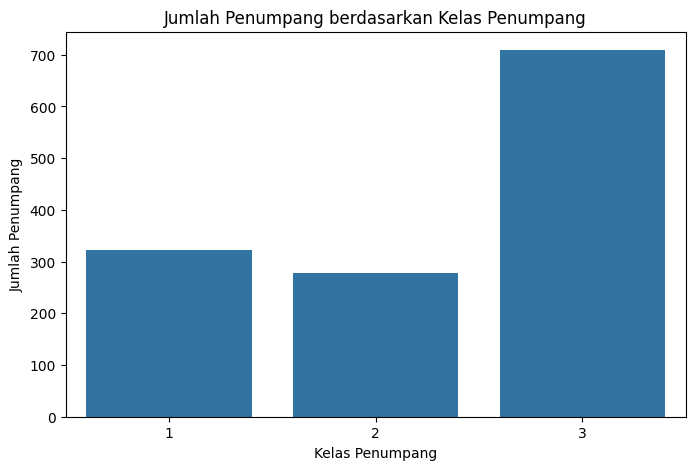

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Menghitung jumlah penumpang berdasarkan kelas
class_counts = df.groupBy('passenger_class').count().toPandas()

# Bar plot
plt.figure(figsize=(8, 5))
sns.barplot(x='passenger_class', y='count', data=class_counts)
plt.title('Jumlah Penumpang berdasarkan Kelas Penumpang')
plt.xlabel('Kelas Penumpang')
plt.ylabel('Jumlah Penumpang')
plt.show()

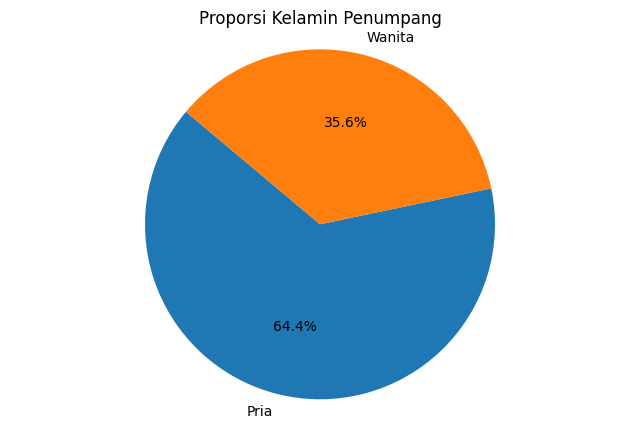

In [ ]:
# Menghitung jumlah penumpang berdasarkan jenis kelamin
sex_counts = df.groupBy('sex').count().toPandas()

# Pie chart
plt.figure(figsize=(8, 5))
plt.pie(sex_counts['count'], labels=['Pria', 'Wanita'], autopct='%1.1f%%', startangle=140)
plt.title('Proporsi Kelamin Penumpang')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

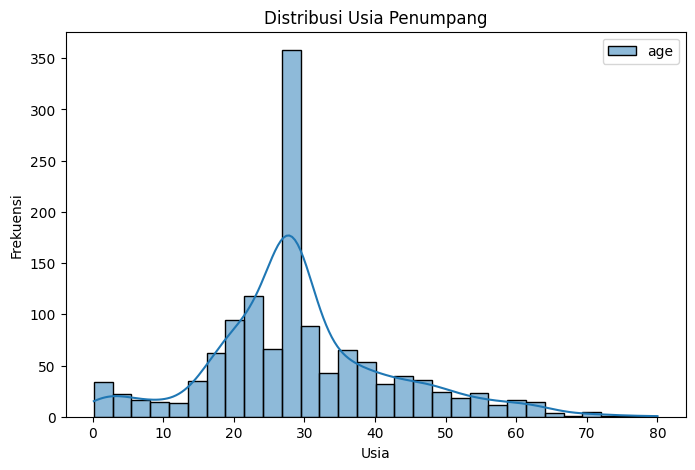

In [ ]:
# Histogram usia
plt.figure(figsize=(8, 5))
sns.histplot(df.select("age").toPandas(), bins=30, kde=True)
plt.title('Distribusi Usia Penumpang')
plt.xlabel('Usia')
plt.ylabel('Frekuensi')
plt.show()

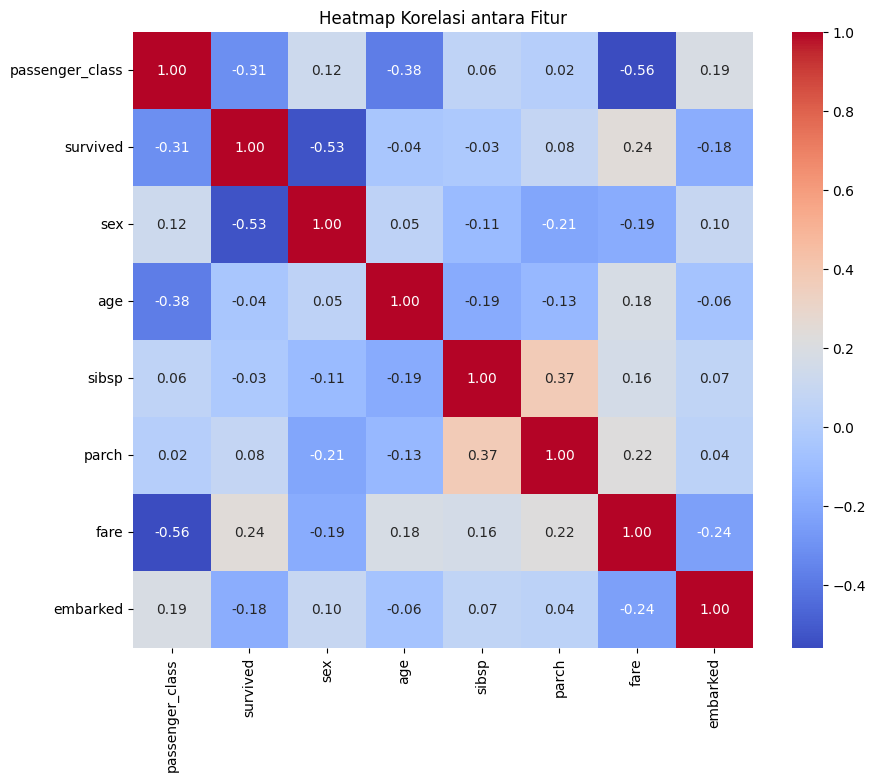

In [ ]:
# Menghapus kolom yang tidak relevan
numeric_features = df.select('passenger_class', 'survived', 'sex', 'age', 'sibsp', 'parch', 'fare', 'embarked')

# Menghitung korelasi hanya untuk fitur numerik
correlation_matrix = numeric_features.toPandas().corr()

# Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Heatmap Korelasi antara Fitur')
plt.show()

#MACHINE LEARNING

In [ ]:
# Menggunakan VectorAssembler untuk menggabungkan fitur
from pyspark.ml.feature import VectorAssembler

# Menentukan fitur dan label
feature_columns = ['passenger_class', 'sex', 'age', 'sibsp', 'parch', 'fare', 'embarked']
assembler = VectorAssembler(inputCols=feature_columns, outputCol='features')

# Mengubah DataFrame
df_transformed = assembler.transform(df)

# Membagi data menjadi training dan testing
training_data, test_data = df_transformed.randomSplit([0.8, 0.2], seed=42)

In [ ]:
# Random Forest
rf = RandomForestClassifier(labelCol='survived', featuresCol='features')
rf_model = rf.fit(training_data)

# Gradient Boosted Trees
gbt = GBTClassifier(labelCol='survived', featuresCol='features')
gbt_model = gbt.fit(training_data)

# Logistic Regression
lr = LogisticRegression(labelCol='survived', featuresCol='features')
lr_model = lr.fit(training_data)

# Decision Tree
dt = DecisionTreeClassifier(labelCol='survived', featuresCol='features')
dt_model = dt.fit(training_data)

In [ ]:
# Import necessary libraries
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier, GBTClassifier, LogisticRegression, DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Prepare features
feature_columns = ['passenger_class', 'sex', 'age', 'sibsp', 'parch', 'fare', 'embarked']
assembler = VectorAssembler(inputCols=feature_columns, outputCol='features')
df_transformed = assembler.transform(df)

# Split the data
training_data, test_data = df_transformed.randomSplit([0.8, 0.2], seed=42)

# Fit models
rf = RandomForestClassifier(labelCol='survived', featuresCol='features')
rf_model = rf.fit(training_data)

gbt = GBTClassifier(labelCol='survived', featuresCol='features')
gbt_model = gbt.fit(training_data)

lr = LogisticRegression(labelCol='survived', featuresCol='features')
lr_model = lr.fit(training_data)

dt = DecisionTreeClassifier(labelCol='survived', featuresCol='features')
dt_model = dt.fit(training_data)

# Evaluate models
def evaluate_model(model, test_data):
    predictions = model.transform(test_data)
    evaluator = MulticlassClassificationEvaluator(labelCol='survived', predictionCol='prediction', metricName='accuracy')
    accuracy = evaluator.evaluate(predictions)
    return accuracy

# Calculate accuracy for all models
rf_accuracy = evaluate_model(rf_model, test_data)
gbt_accuracy = evaluate_model(gbt_model, test_data)
lr_accuracy = evaluate_model(lr_model, test_data)
dt_accuracy = evaluate_model(dt_model, test_data)

print(f"Random Forest Accuracy: {rf_accuracy}")
print(f"Gradient Boosted Trees Accuracy: {gbt_accuracy}")
print(f"Logistic Regression Accuracy: {lr_accuracy}")
print(f"Decision Tree Accuracy: {dt_accuracy}")

Random Forest Accuracy: 0.8141592920353983
Gradient Boosted Trees Accuracy: 0.7787610619469026
Logistic Regression Accuracy: 0.8008849557522124
Decision Tree Accuracy: 0.7831858407079646


#Hyperparameter Tuning

## Tuning untuk Random Forest

In [ ]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Membangun grid untuk Random Forest
paramGrid_rf = ParamGridBuilder() \
    .addGrid(rf.numTrees, [10, 20, 30]) \
    .addGrid(rf.maxDepth, [5, 10, 15]) \
    .build()

# CrossValidator untuk Random Forest
crossval_rf = CrossValidator(estimator=rf,
                              estimatorParamMaps=paramGrid_rf,
                              evaluator=MulticlassClassificationEvaluator(labelCol='survived', predictionCol='prediction', metricName='accuracy'),
                              numFolds=3)

# Fit model
best_rf_model = crossval_rf.fit(training_data)


##Tuning untuk Logistic Regression

In [ ]:
# Membangun grid untuk Logistic Regression
paramGrid_lr = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.01, 0.1, 1.0]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]) \
    .build()

# CrossValidator untuk Logistic Regression
crossval_lr = CrossValidator(estimator=lr,
                              estimatorParamMaps=paramGrid_lr,
                              evaluator=MulticlassClassificationEvaluator(labelCol='survived', predictionCol='prediction', metricName='accuracy'),
                              numFolds=3)

# Fit model
best_lr_model = crossval_lr.fit(training_data)


##Menghitung Metrik Tambahan

In [ ]:
# Fungsi evaluasi untuk menghitung metrik
def evaluate_model(model, test_data):
    predictions = model.transform(test_data)
    evaluator_accuracy = MulticlassClassificationEvaluator(labelCol='survived', predictionCol='prediction', metricName='accuracy')
    evaluator_f1 = MulticlassClassificationEvaluator(labelCol='survived', predictionCol='prediction', metricName='f1')
    evaluator_precision = MulticlassClassificationEvaluator(labelCol='survived', predictionCol='prediction', metricName='weightedPrecision')
    evaluator_recall = MulticlassClassificationEvaluator(labelCol='survived', predictionCol='prediction', metricName='weightedRecall')

    accuracy = evaluator_accuracy.evaluate(predictions)
    f1_score = evaluator_f1.evaluate(predictions)
    precision = evaluator_precision.evaluate(predictions)
    recall = evaluator_recall.evaluate(predictions)

    return accuracy, f1_score, precision, recall

# Evaluasi model terbaik
rf_metrics = evaluate_model(best_rf_model.bestModel, test_data)
lr_metrics = evaluate_model(best_lr_model.bestModel, test_data)

print(f"Random Forest Metrics: Accuracy: {rf_metrics[0]}, F1 Score: {rf_metrics[1]}, Precision: {rf_metrics[2]}, Recall: {rf_metrics[3]}")
print(f"Logistic Regression Metrics: Accuracy: {lr_metrics[0]}, F1 Score: {lr_metrics[1]}, Precision: {lr_metrics[2]}, Recall: {lr_metrics[3]}")

Random Forest Metrics: Accuracy: 0.827433628318584, F1 Score: 0.8235772924729561, Precision: 0.8277773980451364, Recall: 0.8274336283185841
Logistic Regression Metrics: Accuracy: 0.7920353982300885, F1 Score: 0.789532247335242, Precision: 0.7896924599425046, Recall: 0.7920353982300885


#Menyimpan Data yang telah diproses


In [ ]:
# Menyimpan DataFrame yang telah diproses ke dalam file CSV
output_file_path = '/content/drive/MyDrive/BIG DATA LANJUT/Titanic Dataset/processed_data.csv'
df.write.csv(output_file_path, header=True, mode='overwrite')

# Menampilkan pesan berhasil diekspor
print("Data telah berhasil diekspor ke:", output_file_path)

Data telah berhasil diekspor ke: /content/drive/MyDrive/BIG DATA LANJUT/Titanic Dataset/processed_data.csv
